# Clustering Project: Bank Data

Coded by Luna McBride

This one does not have as much of an objective as others. I just saw it and felt compelled.

Sources used for learning in case I want to view them again: https://www.youtube.com/playlist?list=PLcFcktZ0wnNnzAQZL4m_-1Xc66MfnPegq , https://www.kaggle.com/vipulgandhi/kmeans-detailed-explanation

In [114]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans #Clustering use case
from sklearn import metrics as mt #Check metrics on the model
from sklearn.preprocessing import RobustScaler, normalize #Scaling options
from sklearn.decomposition import PCA #Explaining variance

from yellowbrick.cluster import SilhouetteVisualizer #Visualize Silhouette Scores

import matplotlib.pylab as plt #Plotting graphs
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D #Plotting graphs in 3D

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ccdata/CC GENERAL.csv


In [115]:
credit = pd.read_csv("../input/ccdata/CC GENERAL.csv") #Load the dataset into a dataframe
credit.head() #Take a peek at the dataframe

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


---

# Check for nulls

In [116]:
print(credit.count()) #Gets the counts of the columns

#There are some with inconsistent values, being CREDIT_LIMIT and MINIMUM_PAYMENTS

print(credit["CREDIT_LIMIT"].isnull().any()) #Check for nulls in CREDIT_LIMIT
print(credit["MINIMUM_PAYMENTS"].isnull().any()) #Check for nulls in MINIMUM_PAYMENTS

CUST_ID                             8950
BALANCE                             8950
BALANCE_FREQUENCY                   8950
PURCHASES                           8950
ONEOFF_PURCHASES                    8950
INSTALLMENTS_PURCHASES              8950
CASH_ADVANCE                        8950
PURCHASES_FREQUENCY                 8950
ONEOFF_PURCHASES_FREQUENCY          8950
PURCHASES_INSTALLMENTS_FREQUENCY    8950
CASH_ADVANCE_FREQUENCY              8950
CASH_ADVANCE_TRX                    8950
PURCHASES_TRX                       8950
CREDIT_LIMIT                        8949
PAYMENTS                            8950
MINIMUM_PAYMENTS                    8637
PRC_FULL_PAYMENT                    8950
TENURE                              8950
dtype: int64
True
True


Minimum payments appears to have multiple nulls. I think it is fair to replace the nulls with 0 here.
Credit Limits only has one null. I think i will just take the mean of credit limits for this one.

In [117]:
credit["MINIMUM_PAYMENTS"] = credit["MINIMUM_PAYMENTS"].fillna(0) #Fills nulls in MINIMUM_PAYMENTS with 0
credit["CREDIT_LIMIT"] = credit["CREDIT_LIMIT"].fillna(credit["CREDIT_LIMIT"].mean()) #Fills the null in CREDIT_LIMIT with the mean limit
print(credit.count()) #Print the counts

CUST_ID                             8950
BALANCE                             8950
BALANCE_FREQUENCY                   8950
PURCHASES                           8950
ONEOFF_PURCHASES                    8950
INSTALLMENTS_PURCHASES              8950
CASH_ADVANCE                        8950
PURCHASES_FREQUENCY                 8950
ONEOFF_PURCHASES_FREQUENCY          8950
PURCHASES_INSTALLMENTS_FREQUENCY    8950
CASH_ADVANCE_FREQUENCY              8950
CASH_ADVANCE_TRX                    8950
PURCHASES_TRX                       8950
CREDIT_LIMIT                        8950
PAYMENTS                            8950
MINIMUM_PAYMENTS                    8950
PRC_FULL_PAYMENT                    8950
TENURE                              8950
dtype: int64


Nulls have been filled. Most fields are also numeric, so no blank strings to check for. Proceed to the next part.

---

# Column Use Choices

Original Thought Process: 

This is a bank that wants to build a market strategy. The google definition of market strategy is "A marketing strategy refers to a business's overall game plan for reaching prospective consumers and turning them into customers of the products or services the business provides" (For my future self in case I forget). A bank makes money from roping people in for longer amounts of time as well as when making purchases. So, I think the strongest indicators are purchase frequency, balance frequency, and tenure (I do not think the actual amounts of the balance and purchases matter in this case, as it is overall strategy and not "make as much money as possible").

Updated Thought Process:

Upon experimentation, these were not the best choices to make. The Tenure essentially created different graphs based on the tenure number because it is only in years. The frequency parameters also made for spread all across the board instead of more clear clusters, so the numeric values may give more insights.

I now think purchases, balance, and payments are the best play because they exemplify the baseline services of a bank (getting people to have more with the bank, pay them more, and spend more overall to have to pay back) without those key problems.

In [118]:
metric = ["BALANCE", "PURCHASES", "PAYMENTS", "CUST_ID"] #Laying out the metrics stated above plus cust_id for indexing
metricsDf = credit[metric] #Take the metrics from the credit dataframe
metricsDf = metricsDf.set_index("CUST_ID") #Set the customer ID to the index
metricsDf = metricsDf.astype("float") #Converts the types to float to make kmeans more applicable
metricsDf.head() #Display the metrics dataframe

,BALANCE,PURCHASES,PAYMENTS
CUST_ID,,,
C10001,40.900749,95.40,201.802084
C10002,3202.467416,0.00,4103.032597
C10003,2495.148862,773.17,622.066742
C10004,1666.670542,1499.00,0.000000
C10005,817.714335,16.00,678.334763


---

# Visualize and Transform Data

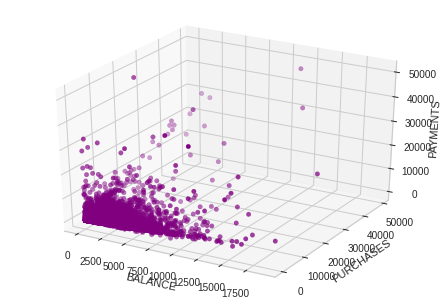

In [119]:
fig = plt.figure() #Build the figure
ax = Axes3D(fig) #Make it 3D

#Define the x y z to be the dataset columns
x = list(metricsDf.iloc[:,0])
y = list(metricsDf.iloc[:,1])
z = list(metricsDf.iloc[:,2])

#Define the axes labels
names = metricsDf.columns
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_zlabel(names[2])

ax.scatter(x, y, z, c = "purple", marker = "o") #Create a scatterplot of the data
plt.show() #Show the graph

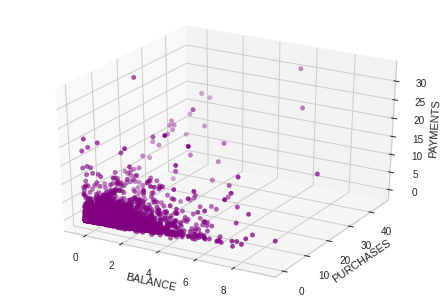

In [120]:
#Scaling with a robust scaler, as messing with it and the min/max and standard scalers showed it to be the best here
robust = RobustScaler()
trainRobust = robust.fit_transform(metricsDf)

fig = plt.figure() #Build the figure
ax = Axes3D(fig) #Make it 3D

#Define the x y z to be the dataset columns
x = trainRobust[:,0]
y = trainRobust[:,1]
z = trainRobust[:,2]

#Define the axes labels
names = metricsDf.columns
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_zlabel(names[2])

ax.scatter(x, y, z, c = "purple", marker = "o") #Create a scatterplot of the robust data
plt.show() #Show the graph

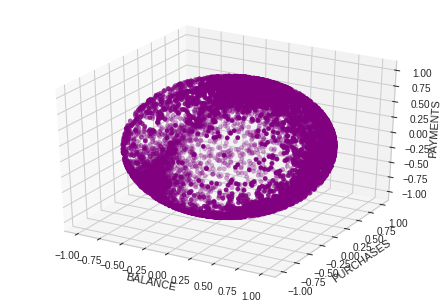

In [121]:
normalRobust = normalize(trainRobust) #Normalize the robust scaled data
fig = plt.figure() #Build the figure
ax = Axes3D(fig) #Make it 3D

#Define the x y z to be the dataset columns
x = normalRobust[:,0]
y = normalRobust[:,1]
z = normalRobust[:,2]

#Define the axes labels
names = metricsDf.columns
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_zlabel(names[2])

ax.scatter(x, y, z, c = "purple", marker = "o") #Create a scatterplot with the normalized data
plt.show() #Show the graph

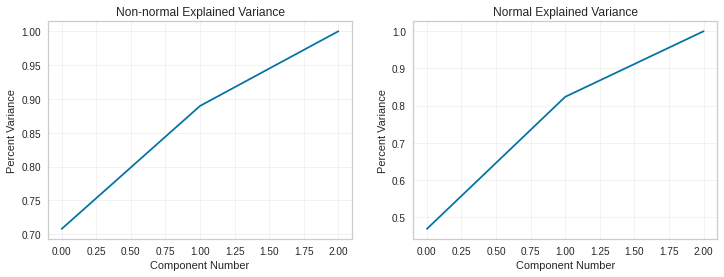

In [122]:
pcaTrain = PCA().fit(trainRobust) #A PCA for just the fit data
pcaNormal = PCA().fit(normalRobust) #A PCA for the normalized data

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(12,4)) #Creates a subplot for both explained variances

#Sets the x and y labels on each graph
axes[0].set_xlabel("Component Number")
axes[0].set_ylabel("Percent Variance")
axes[1].set_xlabel("Component Number")
axes[1].set_ylabel("Percent Variance")

#Sets the titles of the graph, one normal, the other non-normal
axes[0].set_title("Non-normal Explained Variance")
axes[1].set_title("Normal Explained Variance")

#Sets a gray grid below for easier reading
axes[0].grid(alpha=0.25)
axes[1].grid(alpha=0.25)
axes[0].set_axisbelow(True)
axes[1].set_axisbelow(True)

#Plots the explained variance for the normal and non-normal data
axes[0].plot(np.cumsum(pcaTrain.explained_variance_ratio_))
axes[1].plot(np.cumsum(pcaNormal.explained_variance_ratio_))

plt.show() #Shows the plots

According to the graph, one component can explain 90% of the variance on the non-normal data and between 80% and 85% on the normalized data. However, both sets can explain the variance 100% with two components, so it is a toss up on whichever one I choose to use. I like the ball better, so I choose the normalized data.

---

# Create a PCA-modified set

In [123]:
pcaSet = PCA(n_components = 2) #Initialize a PCA with two components
pcaSet = pcaSet.fit_transform(normalRobust) #Insert the normalized data, squashing it into two components
pcaDf = pd.DataFrame(data = pcaSet, columns = ["Component 1", "Component 2"]) #Insert the PCA set into a dataframe
pcaDf.head() #Take a peek at the dataframe

,Component 1,Component 2
0,1.056498,-0.052581
1,-0.769540,0.303562
2,-0.499844,0.501555
3,-0.154065,-0.128776
4,0.743271,0.652523


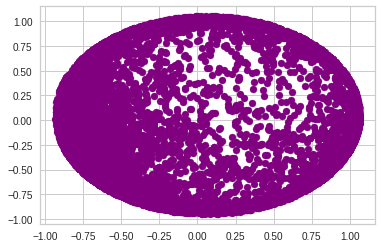

In [124]:
plt.figure() #Build a figure

#Set the axes to the components
axes[0].set_xlabel("Component 1")
axes[0].set_ylabel("Component 2")
axes[0].set_title("2 Component PCA")

#Take a look at the orb
plt.scatter(pcaDf["Component 1"], pcaDf["Component 2"], c="purple")

---

# Silhouette Analysis

In [125]:
results = {}
numClusters = 11

for k in range(2 , numClusters):
    print("-"*100) #Separate the iterations
    results[k] = {} #Collect the results at K
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(pcaDf) #Run the kmeans for k
    silhouette = mt.silhouette_score(pcaDf, kmeans.labels_, metric = "euclidean") #Get the silhouette score
    
    #Put the scores into the results dictionary
    results[k]["Silhouette"] = silhouette
    results[k]["Score"] = kmeans.score
    results[k]["Inertia"] = kmeans.inertia_
    
    #Print the results
    print("Clusters: {}".format(k))
    print("Silhouette Score: {}".format(silhouette))

----------------------------------------------------------------------------------------------------
Clusters: 2
Silhouette Score: 0.47306304437369234
----------------------------------------------------------------------------------------------------
Clusters: 3
Silhouette Score: 0.5285088171247183
----------------------------------------------------------------------------------------------------
Clusters: 4
Silhouette Score: 0.5168591585055019
----------------------------------------------------------------------------------------------------
Clusters: 5
Silhouette Score: 0.4943634365846701
----------------------------------------------------------------------------------------------------
Clusters: 6
Silhouette Score: 0.49787872995783244
----------------------------------------------------------------------------------------------------
Clusters: 7
Silhouette Score: 0.4730682738394558
--------------------------------------------------------------------------------------------------

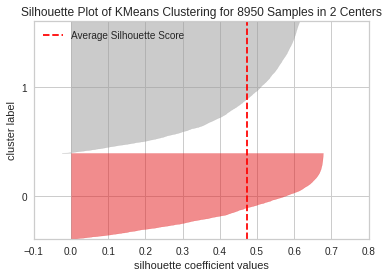

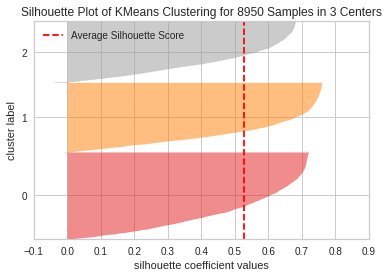

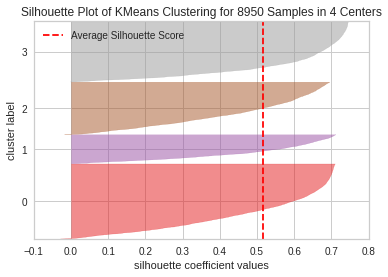

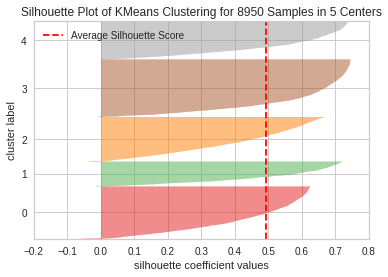

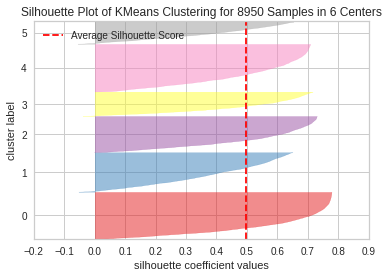

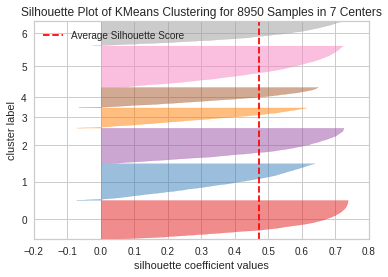

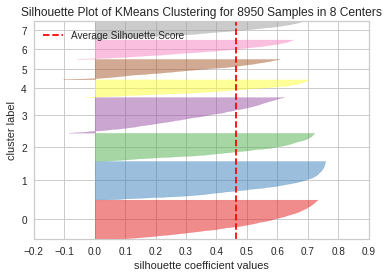

In [126]:
clusters = [2, 3, 4, 5, 6, 7, 8] #Choose a couple clusters to visualize
for cluster in clusters:
    kmeans = KMeans(n_clusters = cluster, random_state = 0) #Run KMeans
    visualize = SilhouetteVisualizer(kmeans) #Set a visualizer for KMeans
    visualize.fit(pcaDf) #Fit the visualizer to the data
    visualize.poof() #Display the visualization

3 clusters look best. All are about the same width and peak over the average

---

# Assign Cluster Centers

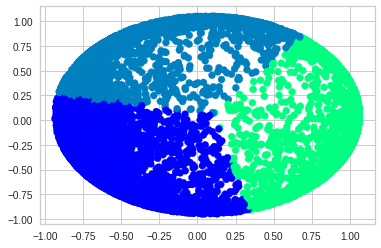

In [127]:
plt.figure() #Build a figure

#Set the axes to the components
axes[0].set_xlabel("Component 1")
axes[0].set_ylabel("Component 2")
axes[0].set_title("2 Component PCA")

#Take a look at the orb
plt.scatter(pcaDf["Component 1"], pcaDf["Component 2"], c = KMeans(n_clusters = 3).fit_predict(pcaDf), cmap =plt.cm.winter) 
plt.show() 

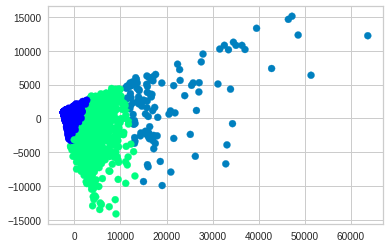

In [128]:
fig = plt.figure() #Build the figure
pcaSetTrain = PCA(n_components = 2) #Initialize a PCA with two components
pcaSetTrain = pcaSetTrain.fit_transform(metricsDf) #Insert the normalized data, squashing it into two components
pcaDfTrain = pd.DataFrame(data = pcaSetTrain, columns = ["Component 1", "Component 2"]) #Insert the PCA set into a dataframe

#Scatter based off the original set
plt.scatter(pcaDfTrain["Component 1"], pcaDfTrain["Component 2"], c = KMeans(n_clusters = 3).fit_predict(pcaDfTrain), cmap =plt.cm.winter, marker = "o") 
plt.show() 

---

# Deriving data from the clusters

In [132]:
info = metricsDf.copy() #Get a copy of the original data
info["Cluster"] = KMeans(n_clusters = 3).fit_predict(pcaDf) #Add a column for which cluster each was classified as
info.head() #Show the new dataframe

,BALANCE,PURCHASES,PAYMENTS,Cluster
CUST_ID,,,,
C10001,40.900749,95.40,201.802084,0
C10002,3202.467416,0.00,4103.032597,2
C10003,2495.148862,773.17,622.066742,2
C10004,1666.670542,1499.00,0.000000,1
C10005,817.714335,16.00,678.334763,0


In [135]:
sums = [0, 0, 0, 0, 0, 0, 0, 0, 0] #A list to hold the sum of each classification, 0-2 for cluster 0, 3-5 for cluster 1, and 6-8 for 2
counts = [0, 0, 0] #Counts for each cluster, the cluster number being the same as the index.
clust = info["Cluster"].copy() #Get the cluster classifications

#For loop to get the sums of each field based off each cluster classification
for i in range(0,len(clust)):
    currentCluster = clust[i] #Get the current cluster
    
    #If in cluster 0
    if currentCluster == 0:
        #Sum the balances, purchases, and payments for cluster 0
        sums[0] = sums[0] + info["BALANCE"][i]
        sums[1] = sums[1] + info["PURCHASES"][i]
        sums[2] = sums[2] + info["PAYMENTS"][i]
        counts[0] += 1
        
    #If in cluster 1
    elif currentCluster == 1:
        #Sum the balances, purchases, and payments for cluster 1
        sums[3] = sums[3] + info["BALANCE"][i]
        sums[4] = sums[4] + info["PURCHASES"][i]
        sums[5] = sums[5] + info["PAYMENTS"][i]
        counts[1] += 1
    
    #If in cluster 2
    else:
        #Sum the balances, purchases, and payments for cluster 2
        sums[6] = sums[6] + info["BALANCE"][i]
        sums[7] = sums[7] + info["PURCHASES"][i]
        sums[8] = sums[8] + info["PAYMENTS"][i]
        counts[2] += 1
    
mean0 = [sums[0]/counts[0], sums[1]/counts[0], sums[2]/counts[0]] #Calculate the means for cluster 0
mean1 = [sums[3]/counts[1], sums[4]/counts[1], sums[5]/counts[1]] #Calculate the means for cluster 1
mean2 = [sums[6]/counts[2], sums[7]/counts[2], sums[8]/counts[2]] #Calculate the means for cluster 2

#Print the mean arrays for each cluster
print("             Balance             Purchases         Payments")
print("Cluster 0: ", mean0)
print("Cluster 1: ", mean1)
print("Cluster 2: ", mean2)

             Balance             Purchases         Payments
Cluster 0:  [262.3915573858494, 244.3922551411647, 343.36372654339385]
Cluster 1:  [1391.094399515262, 2124.3446877625333, 3206.927953085411]
Cluster 2:  [3299.462242593626, 275.4928286852598, 1224.9351488848574]


The three groups appear to be the less engaged (lower in all fronts), the heavy spenders (high spending and credit payments, but a medium amount held by the bank as a balance), and the savers (high balances for purchases, but less spending in the form of purchases and payments

Based on the clusters and these means, I feel it is fair to assume that Balance and Payments are the two components strongly considered in the models by how separate their values are. This tells me that the bank's marketing strategy should focus more on getting users to deposit more and pay more. I had also noticed previously that most of this dataset is pretty high in tenure, so a strong strategy in targeting new people is offering benefits based on how much they deposit into the bank. As for payments, these are likely to be referring to credit card payments in this dataset. Since payments increase with increased credit use, building trust in the bank to be willing to use that much credit seems like a strong strategy in that regard.